## Results of point pollution dilbit spill scenarios at Turn Point
Plotting functions for comparing survival and recovery of groups of species within a single model scenario from the Salish Sea Atlantis Model

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

### Define scenario and control files

In [2]:
# Read in salish sea atlantis output files.
# scenario_path = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/')
# scens = sorted([p for p in scenario_path.glob('*Scenario_5b*/outputSalishSeaBiomIndx.txt')])

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/control_v6666mod/outputSalishSea.nc"
scenario1_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_5b_2019-01-14_redo/outputSalishSea.nc" #neap
scenario2_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_5b_2019-01-20/outputSalishSea.nc" #spring
scenario3_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_5b_2020-01-11_28/outputSalishSea.nc" #spring
scenario4_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_5b_2020-01-16_28/outputSalishSea.nc" #neap

control = xr.open_dataset(str(control_file), decode_cf=True)
scenario1 = xr.open_dataset(str(scenario1_file), decode_cf=True)
scenario2 = xr.open_dataset(str(scenario2_file), decode_cf=True)
scenario3 = xr.open_dataset(str(scenario3_file), decode_cf=True)
scenario4 = xr.open_dataset(str(scenario4_file), decode_cf=True)

t = np.ma.filled(control.variables['t'], np.nan)


In [3]:
scenarios = [scenario1, scenario2, scenario3, scenario4]
scenarios2019 = [scenario1, scenario2]
scenarios2020 = [scenario3, scenario4]

In [4]:
# start and end time of data display, after burn-in
start = 0
end = t.size-1

time = t[start:end]

spill_start1 = np.datetime64('2019-01-01')
spill_start2 = np.datetime64('2020-01-01')

### Results

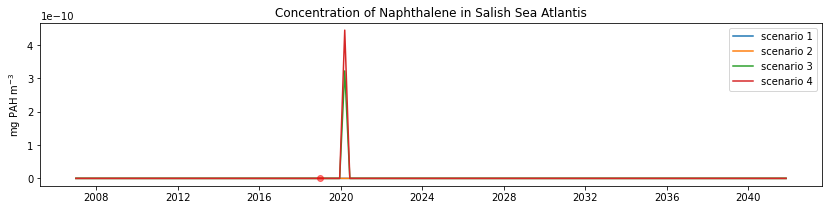

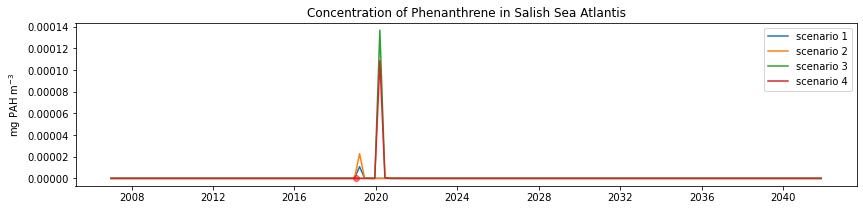

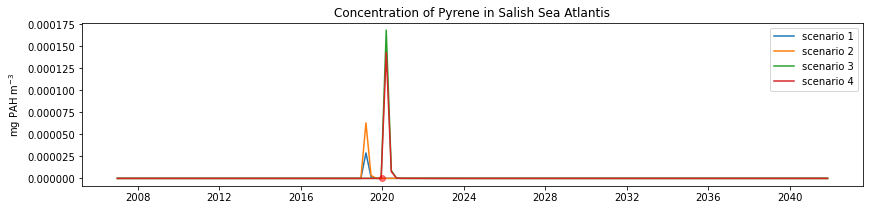

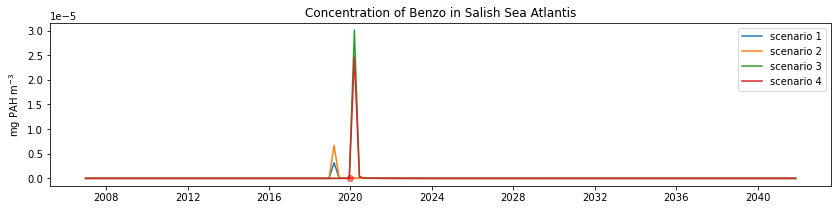

In [5]:
splot.compare_pah('Naphthalene', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start1)
splot.compare_pah('Phenanthrene', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start1)
splot.compare_pah('Pyrene', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start2)
splot.compare_pah('Benzo', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start2)

Naphthalene in 2019

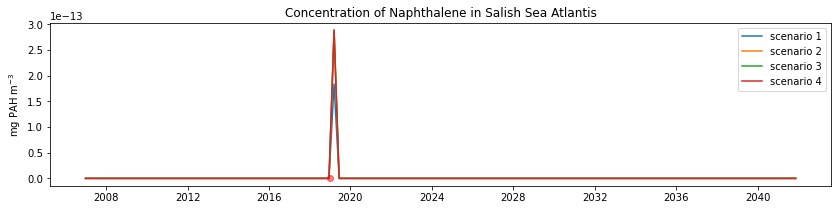

In [6]:
splot.compare_pah('Naphthalene', scenario1, scenario2, scenario2, scenario2, time, start, end, spill_start1)

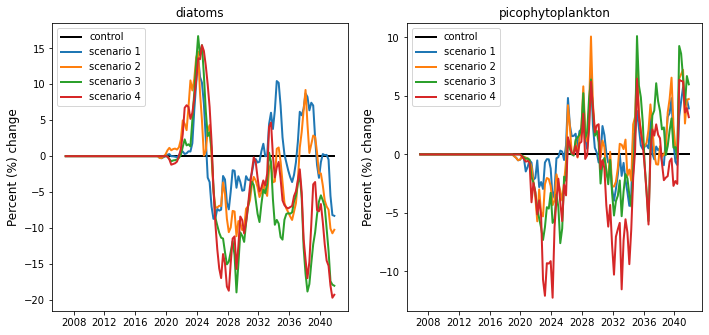

In [7]:
splot.pelagic_compare_scenarios(groups.phytoplankton, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

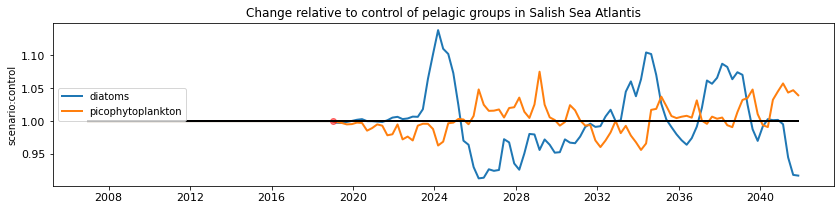

In [8]:
splot.plot_pelagic(groups.phytoplankton, scenario1, control, time, start, end, spill_start1)

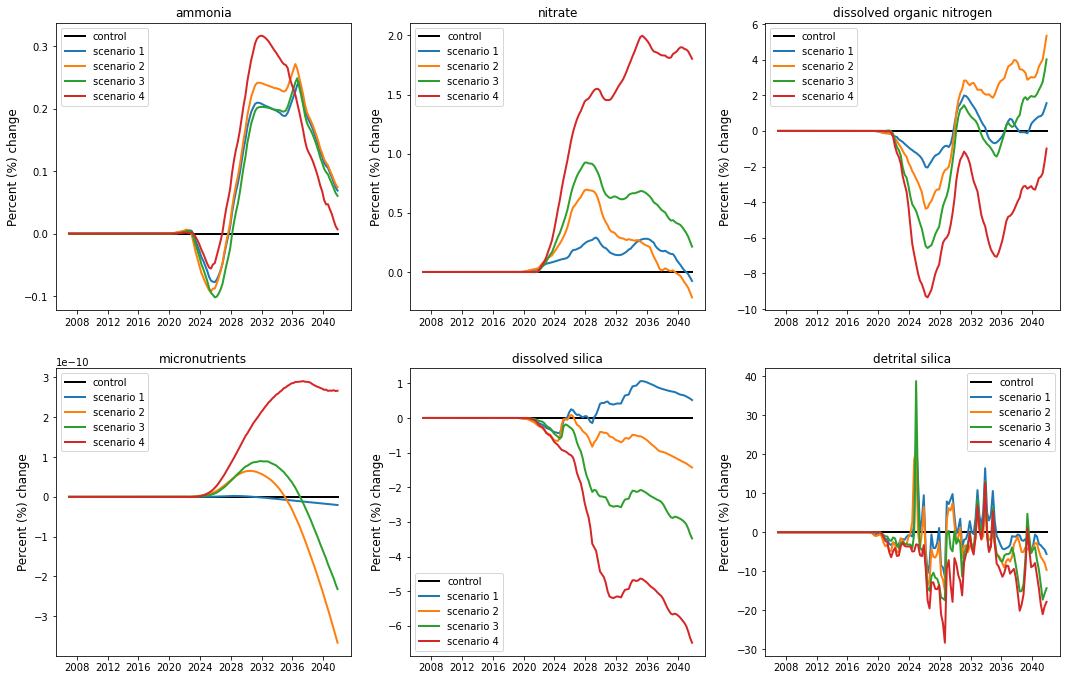

In [10]:
splot.pelagic_compare_nutrients(groups.nutrients, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

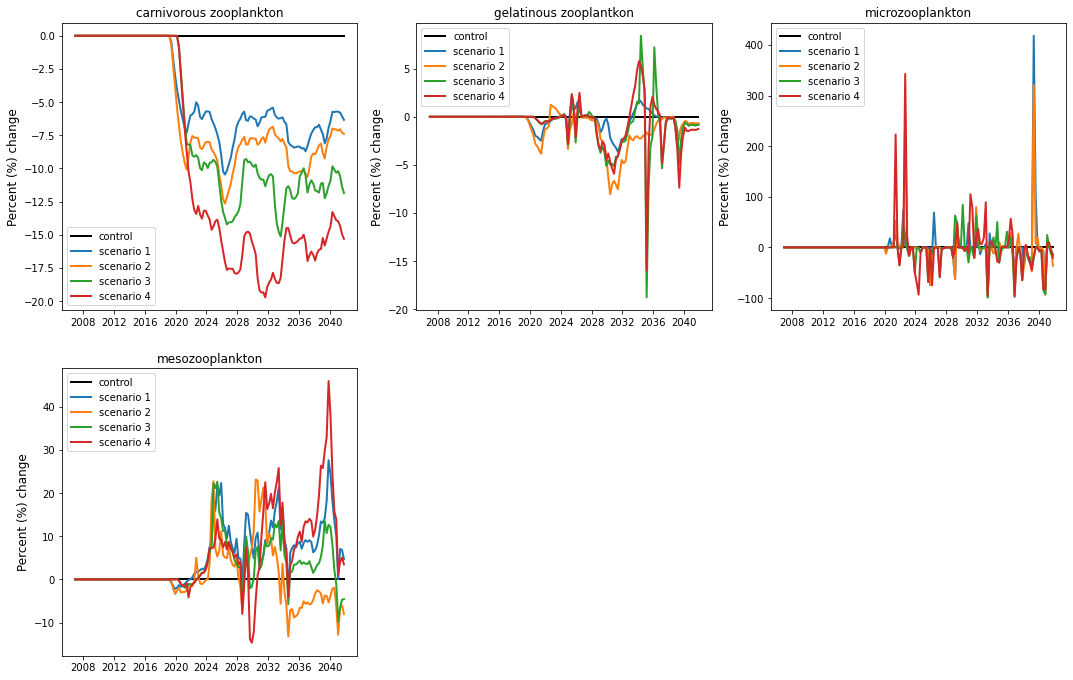

In [11]:
splot.pelagic_compare_scenarios(groups.zooplankton, scenario1, scenario2, scenario3, scenario4, control, time, start, end)

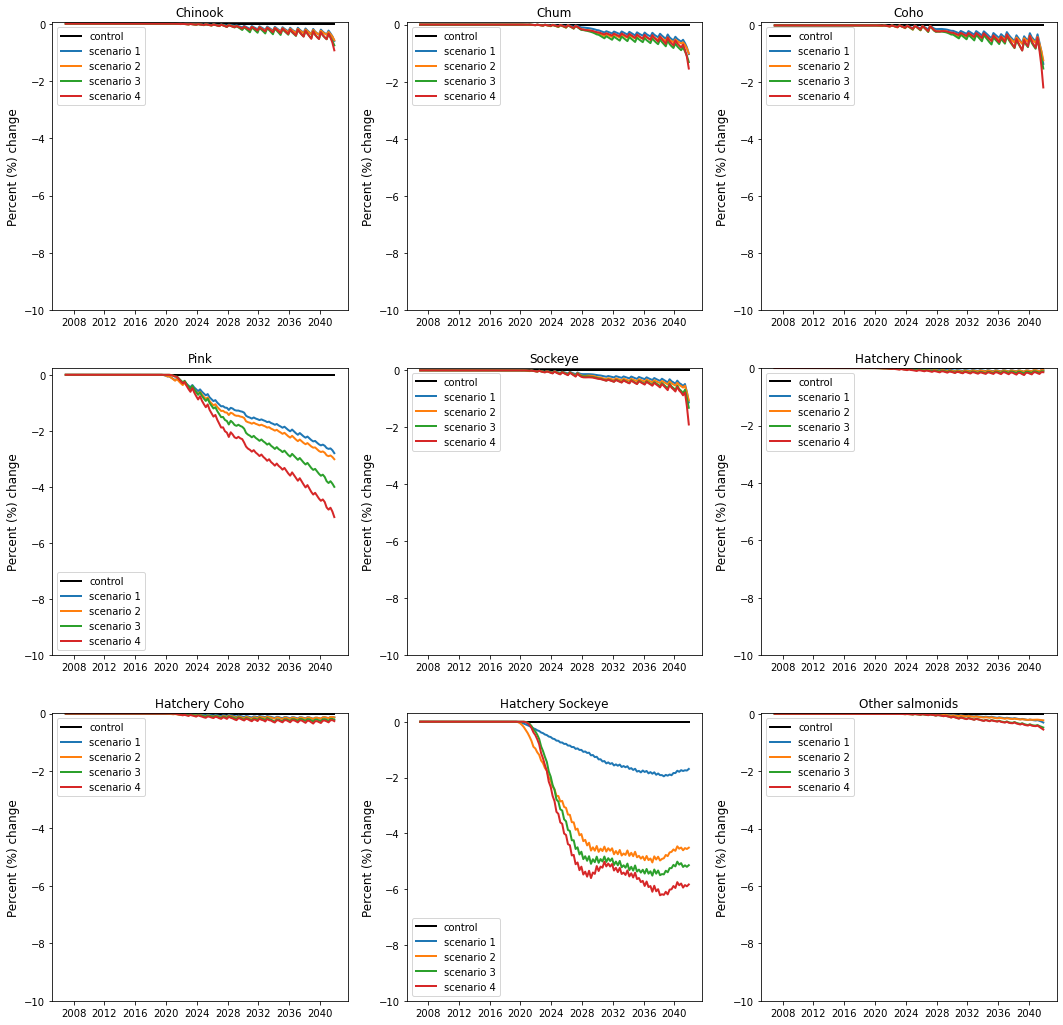

In [12]:
splot.pelagic_compare_scenarios(groups.salmon, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-10, y_max=None)

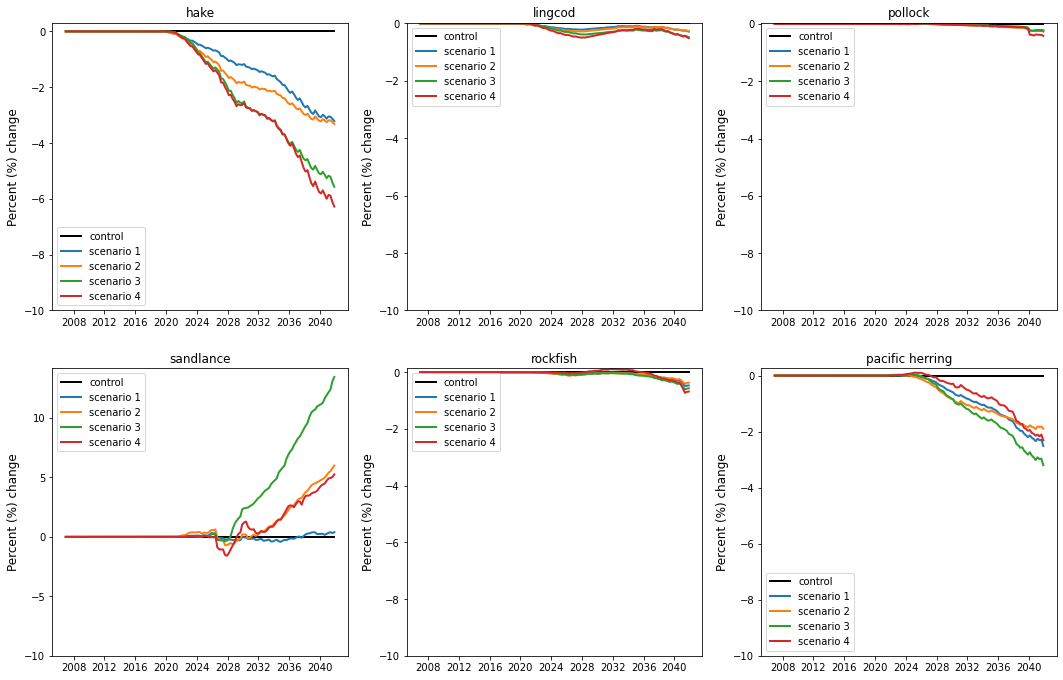

In [13]:
splot.pelagic_compare_scenarios(groups.named_fish, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-10, y_max=None)

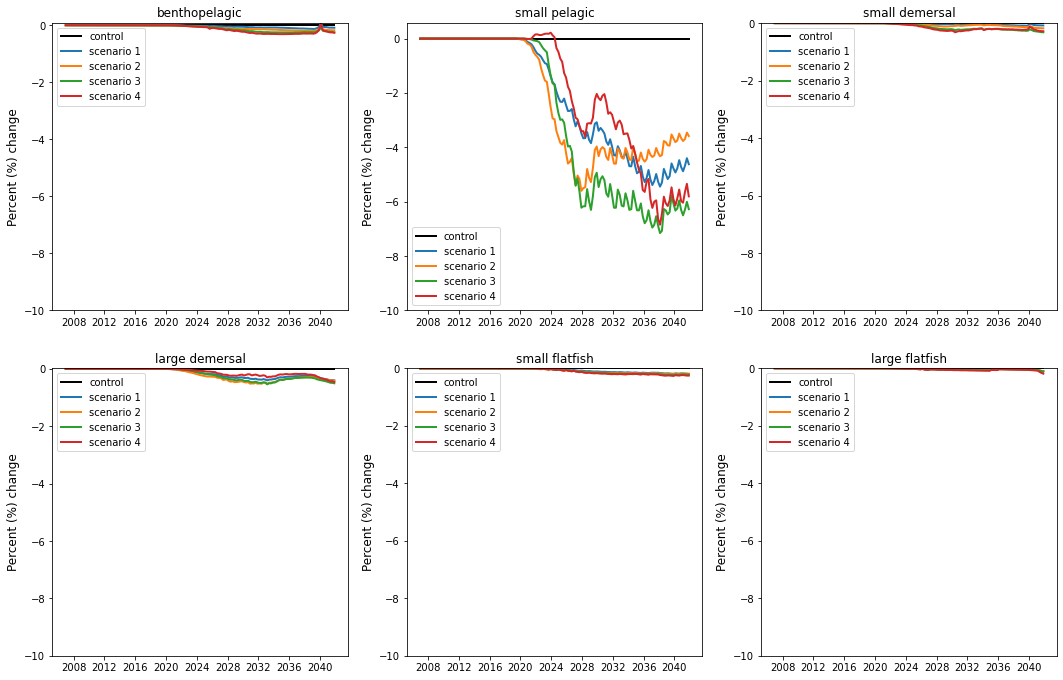

In [14]:
splot.pelagic_compare_scenarios(groups.other_fish, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-10, y_max=None)

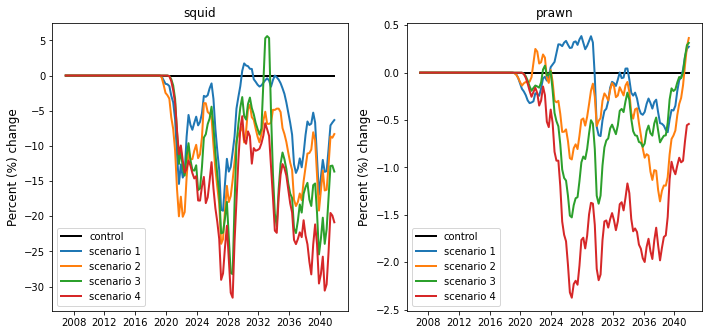

In [29]:
splot.pelagic_compare_scenarios(groups.pelagic_invertebrates, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

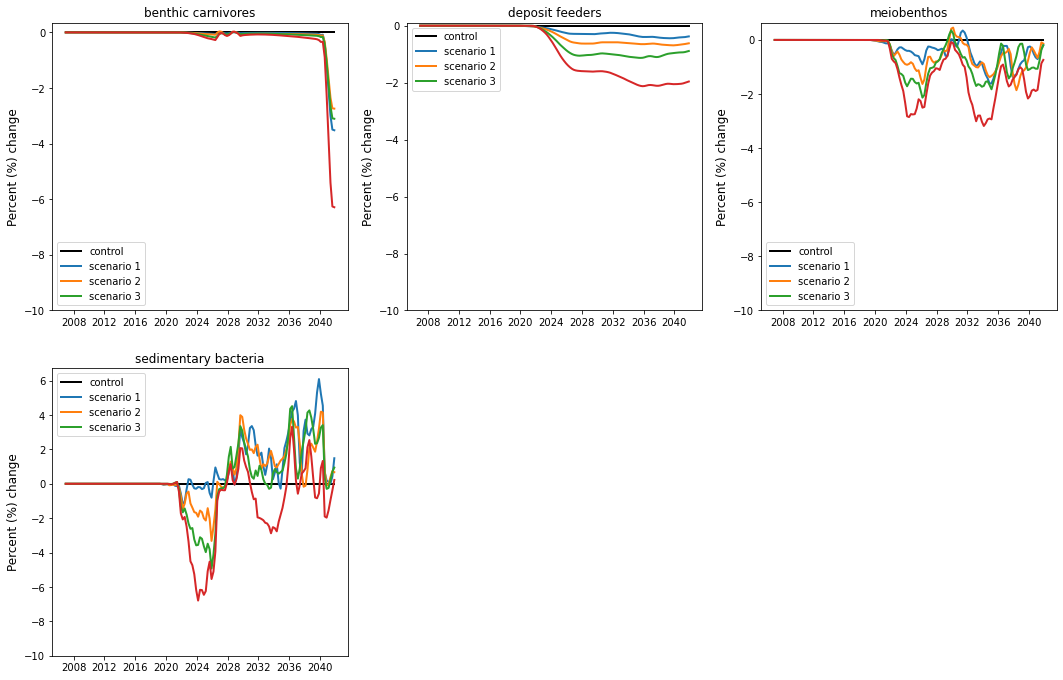

In [16]:
splot.sediment_compare_scenarios(groups.sediment_feeders, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-10, y_max=None)

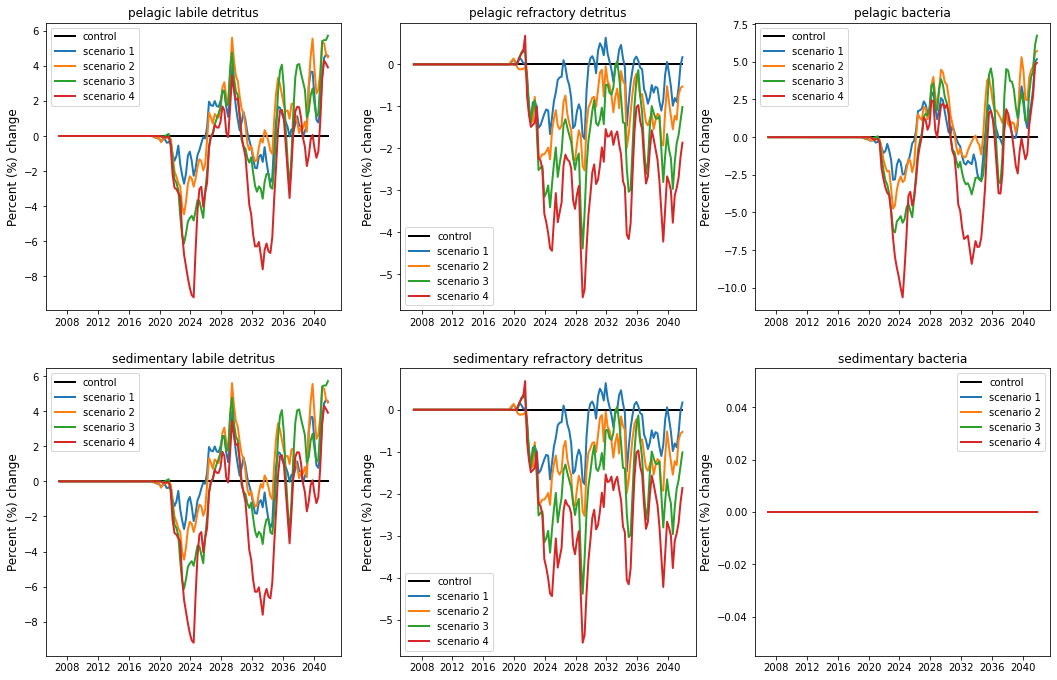

In [17]:
splot.pelagic_compare_scenarios(groups.bacteria, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

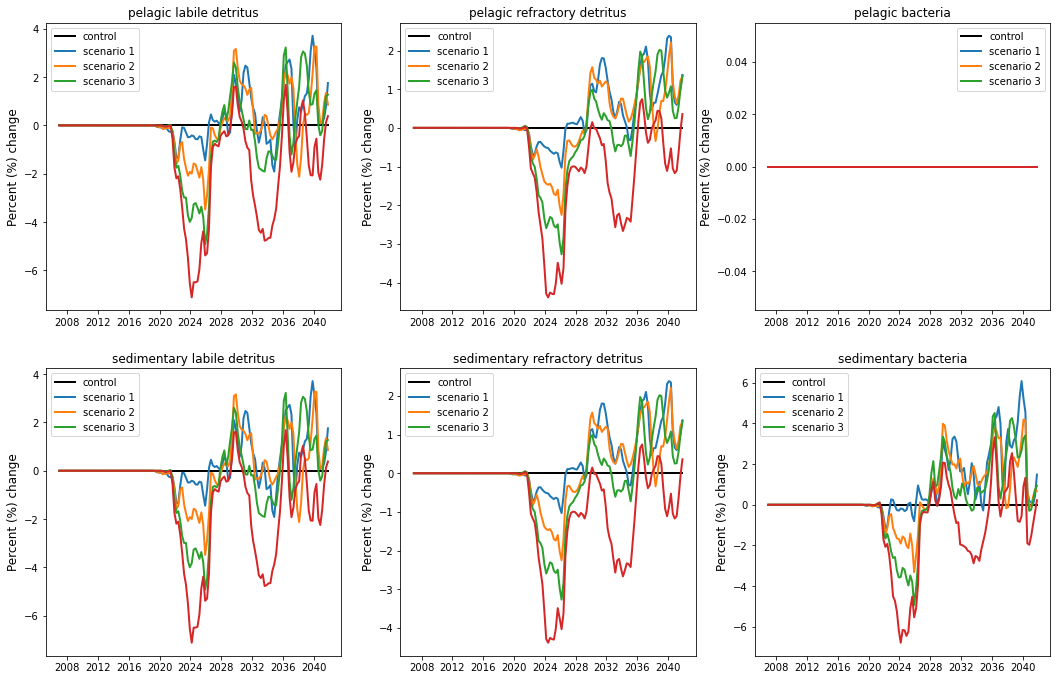

In [18]:
splot.sediment_compare_scenarios(groups.bacteria, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

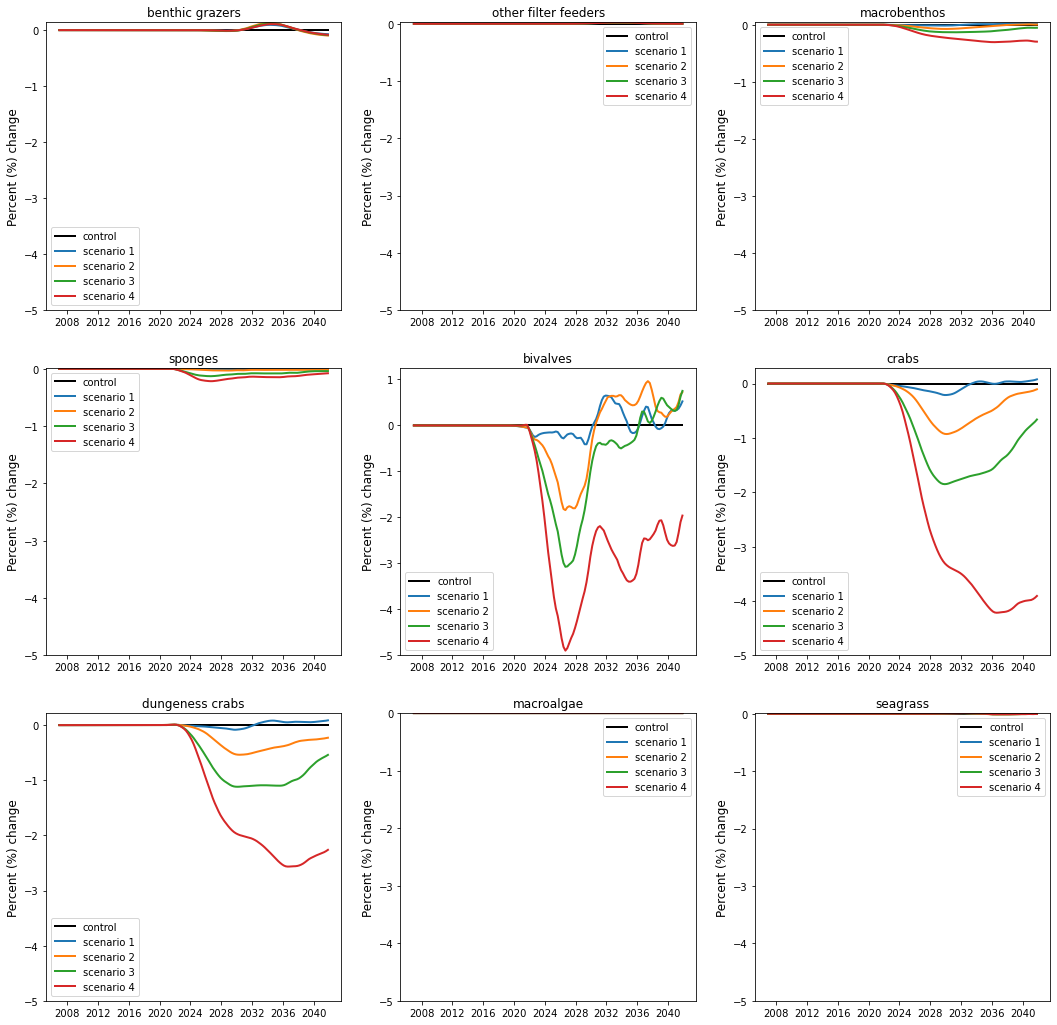

In [19]:
splot.benthic_compare_scenarios(groups.benthos, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-5, y_max=None)

### Assessing specific periods post-spill

In [20]:
print('closest time points to spill: ' + str(t[49]))
print('5 years post spill: ' + str((t[69])))
print('10 years post spill: ' + str(t[89]))
print('20 years post spill: ' + str(t[129]))

closest time points to spill: 2019-03-13T14:00:00.000000000
5 years post spill: 2024-03-06T14:00:00.000000000
10 years post spill: 2029-02-28T14:00:00.000000000
20 years post spill: 2039-02-16T14:00:00.000000000


In [21]:
days2019winter = [49, 69, 89, 129]
days2020winter = [53, 73, 93, 133]
data_label = {'spill year': [], '5 years later': [], '10 years later': [], '20 years later': []}

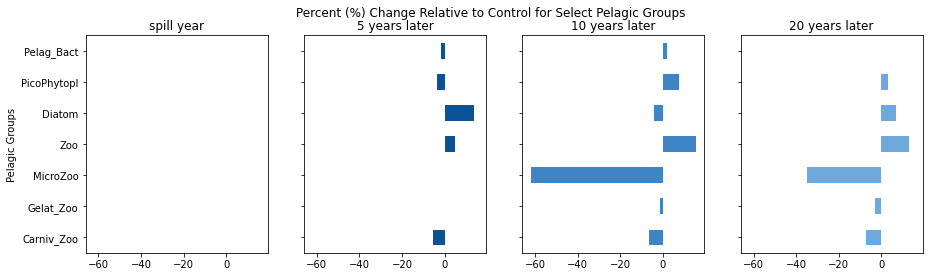

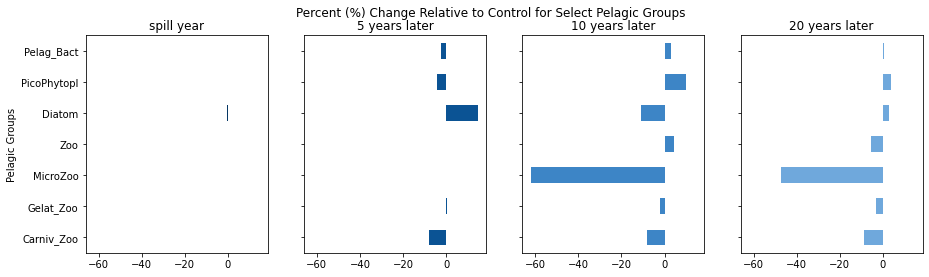

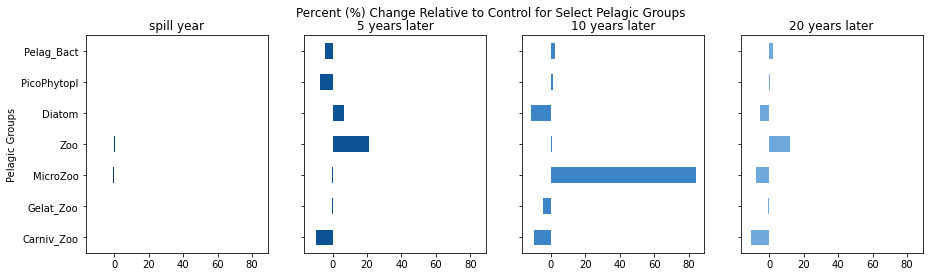

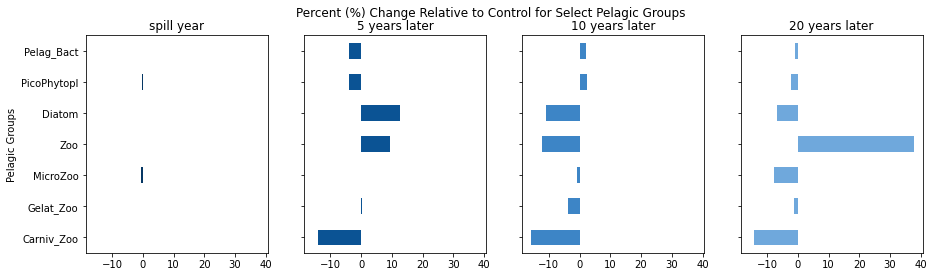

In [22]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.plankton,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.plankton,scenario,control,days2020winter,data_label)

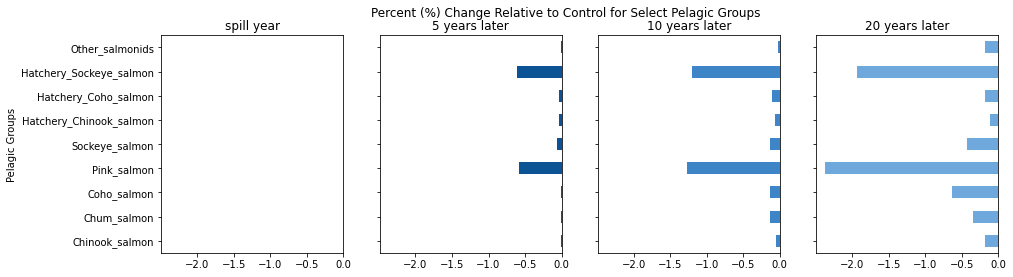

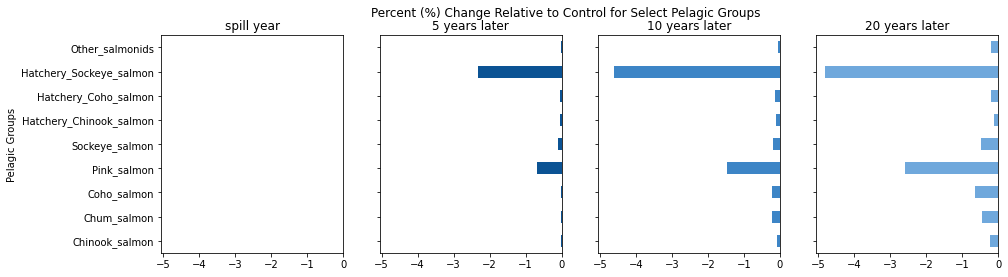

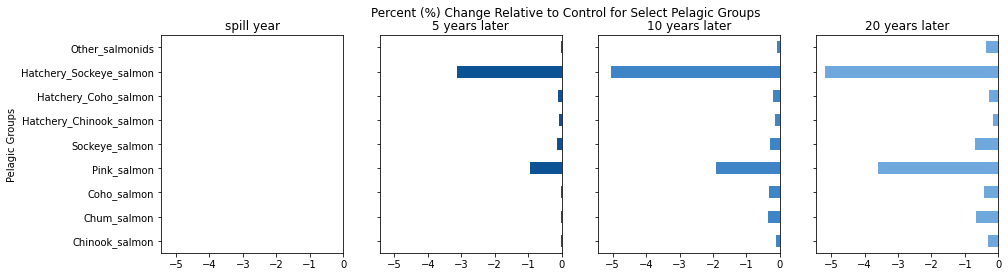

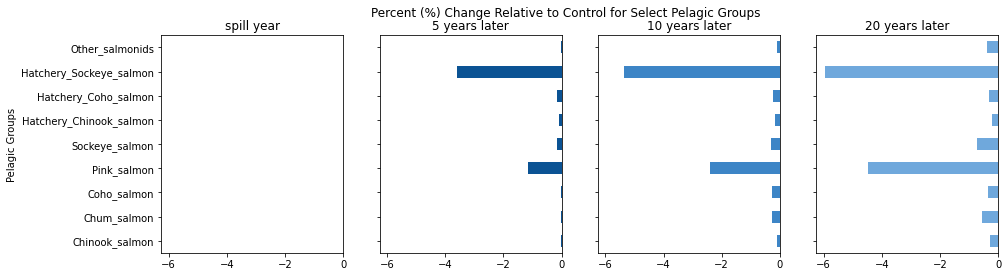

In [23]:

for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.salmon,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.salmon,scenario,control,days2020winter,data_label)

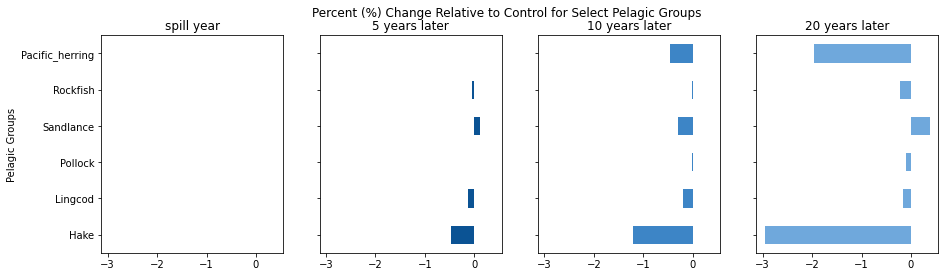

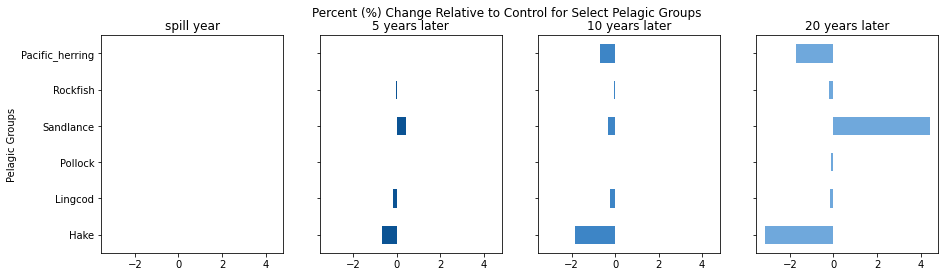

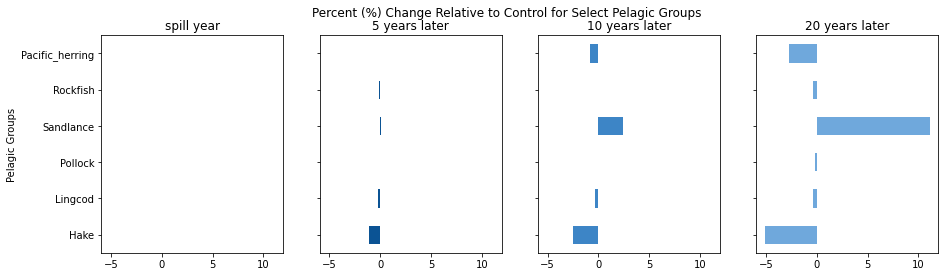

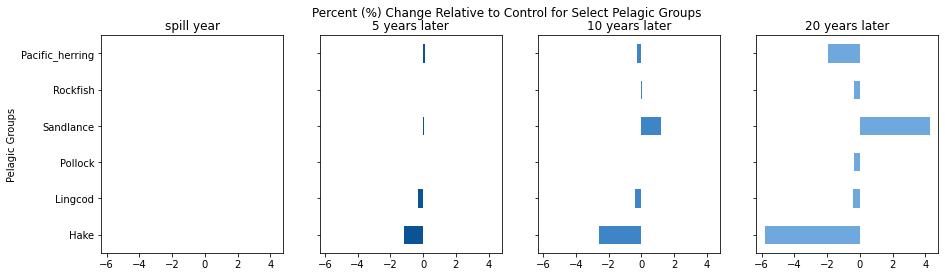

In [24]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.named_fish,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.named_fish,scenario,control,days2020winter,data_label)

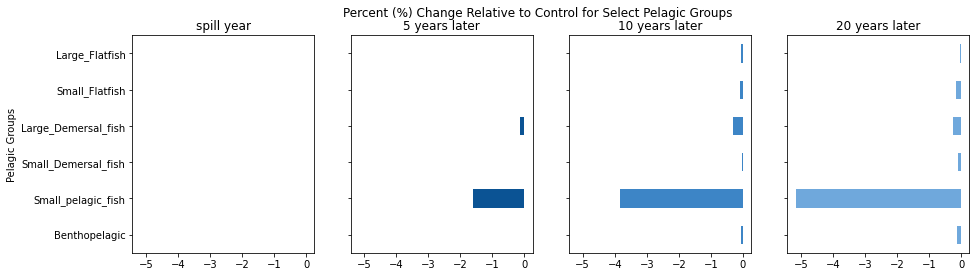

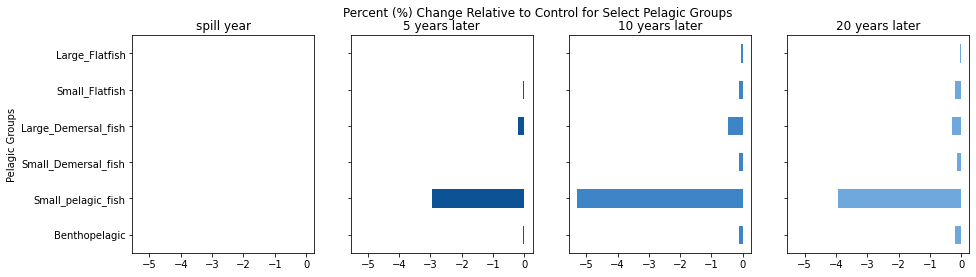

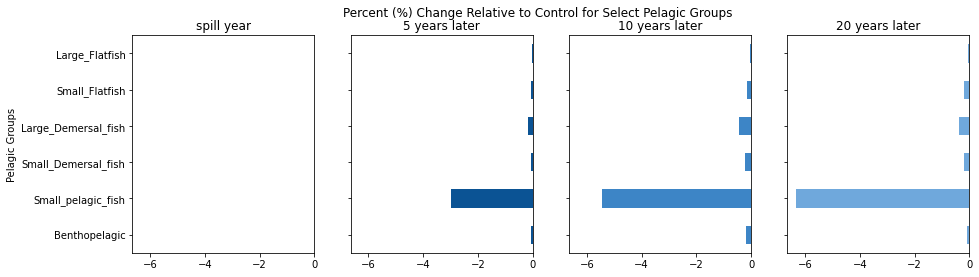

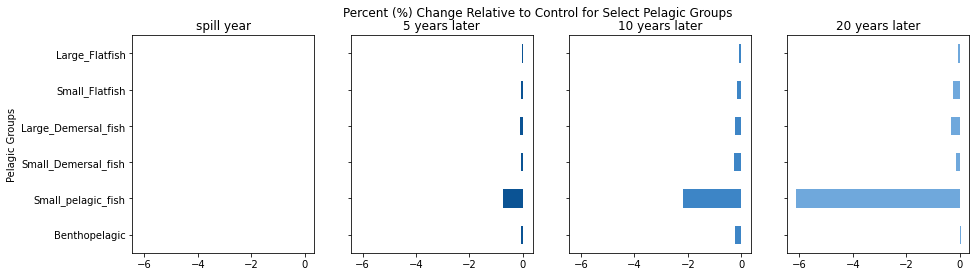

In [25]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.other_fish,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.other_fish,scenario,control,days2020winter,data_label)

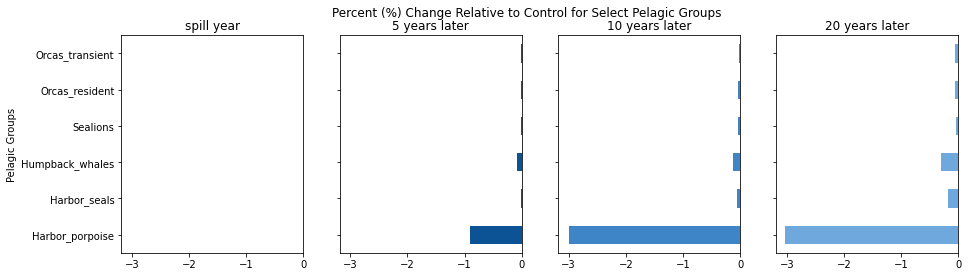

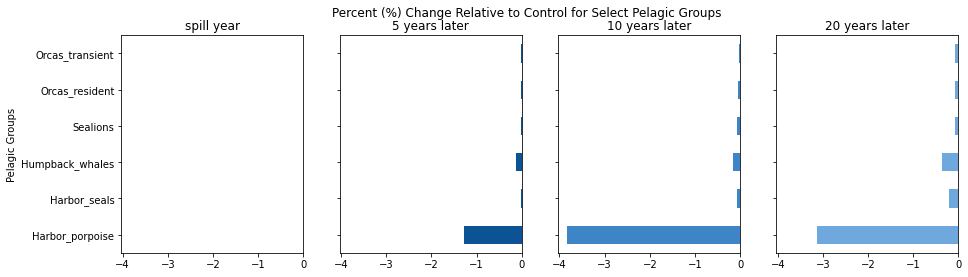

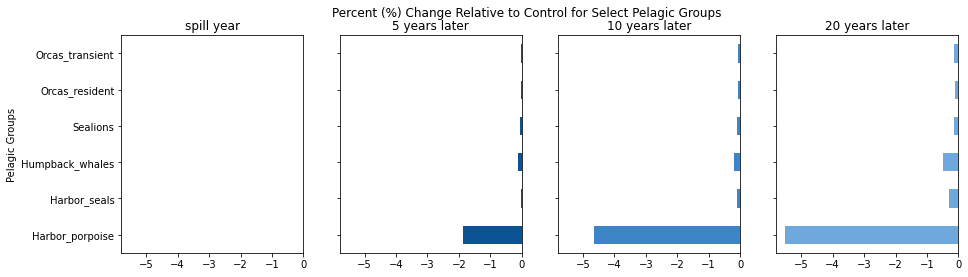

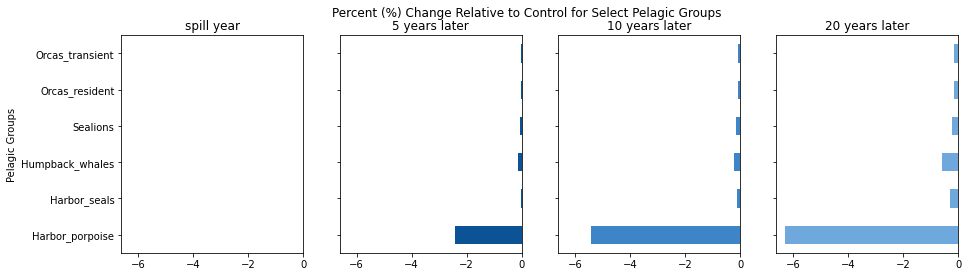

In [26]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.mammals,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.mammals,scenario,control,days2020winter,data_label)

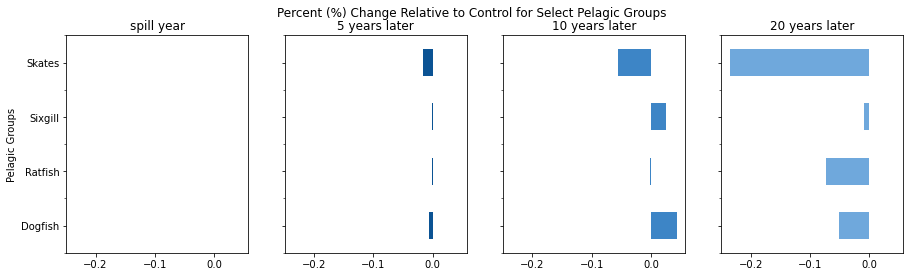

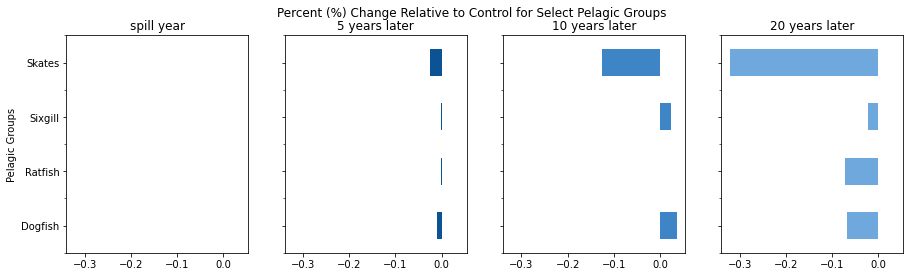

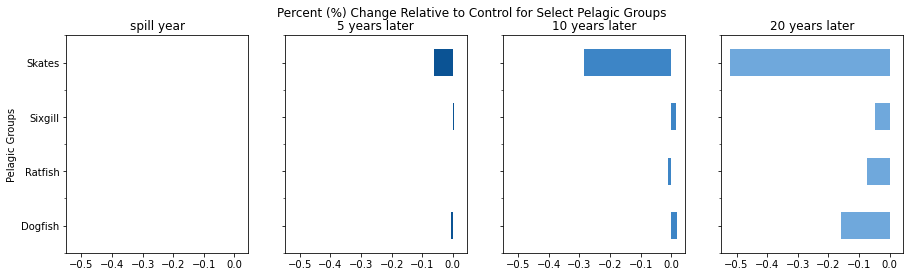

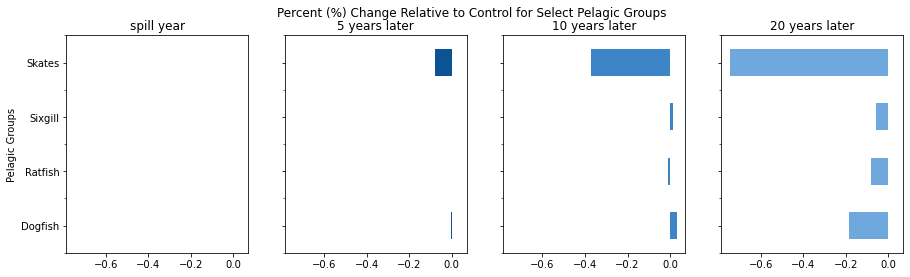

In [27]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.sharks,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.sharks,scenario,control,days2020winter,data_label)

### Map display

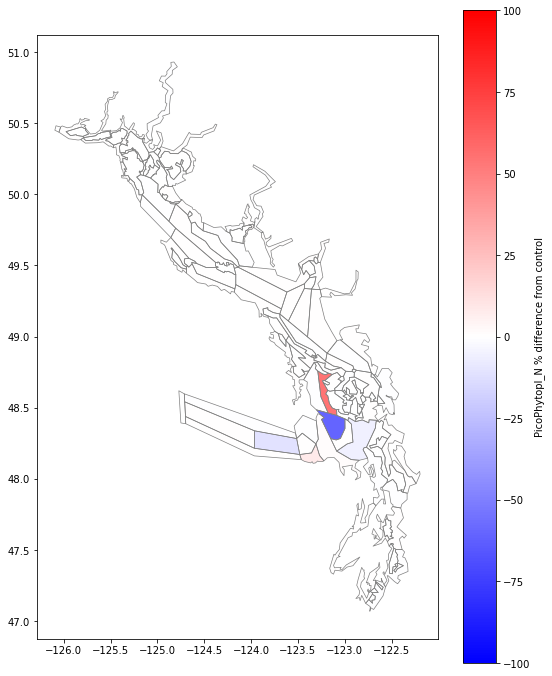

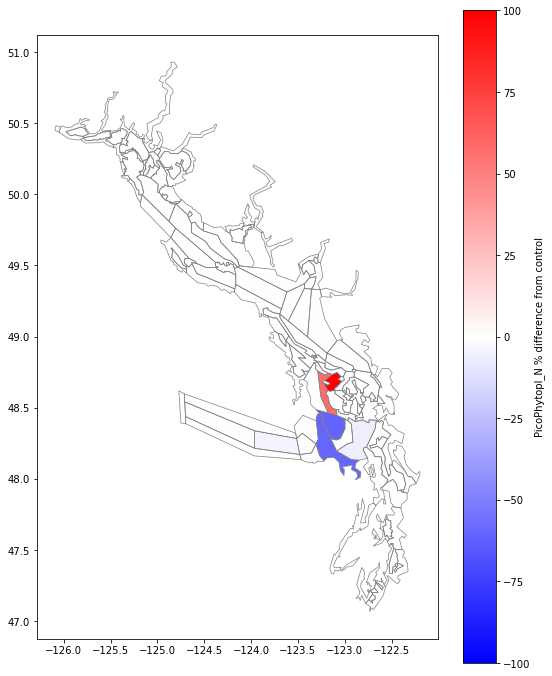

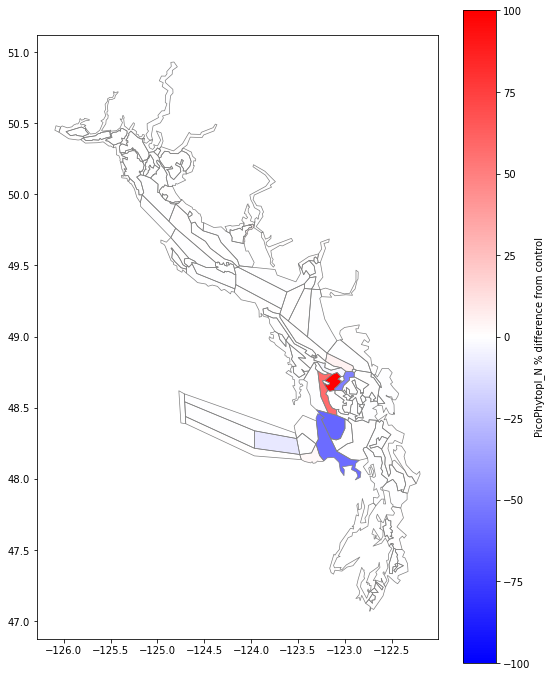

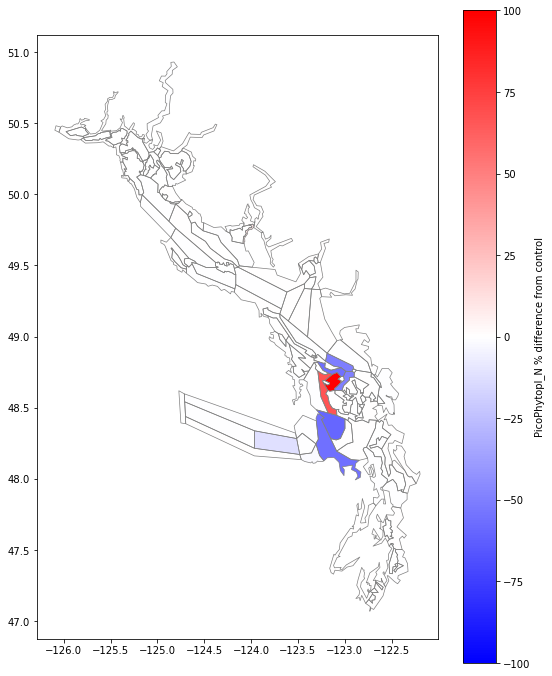

In [30]:
for scenario in scenarios:
    splot.map_pelagic_aggregate_time('PicoPhytopl_N', scenario, control)

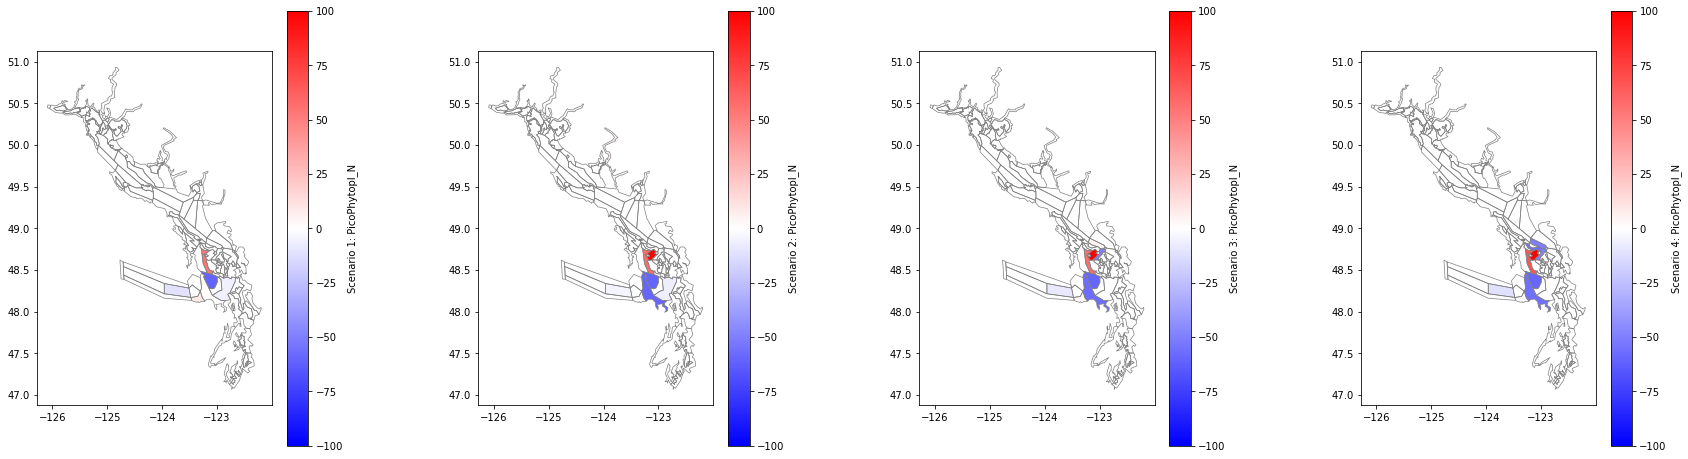

In [31]:
splot.map_pelagic_aggregate_time4('PicoPhytopl_N', scenario1, scenario2, scenario3, scenario4, control, v_max=100, v_min=-100)

##### Pulling data from the outputSalishSeaBiomIndx.txt file
df = pd.DataFrame(columns = ['scenario 1', 'scenario 2', 'scenario 3', 'scenario 4'])

scen_path = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/')
scens = sorted([p for p in scen_path.glob('*Scenario_5b*/outputSalishSeaBiomIndx.txt')])
for path in scens:
    biomass = pd.read_csv(path, sep=" ")
    df.append(biomass.PS)

fig, ax = plt.subplots()
data.plot.barh(ax=ax)  # ax=ax lets the dataframe plot use the subplot axes
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');  # place the legend outside

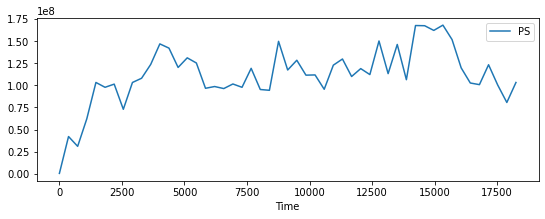

In [32]:
control_data_path = '/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/control_v6666mod/outputSalishSeaBiomIndx.txt'
contr = pd.read_csv(control_data_path, sep=" ")
contr.plot('Time','PS', figsize=(9, 3));

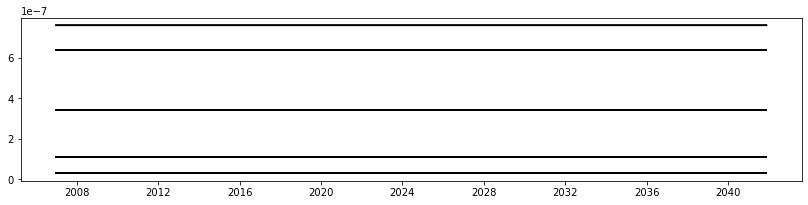

In [33]:
pelagic_control = np.ma.filled(control.variables['PicoPhytopl_N'][start:end,:,0:5], np.nan)
#pelagic_control = pelagic_control.sum(axis=2)
pelagic_control = pelagic_control.sum(axis=1)

fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time[start:end], pelagic_control, 'k', linewidth = 2);

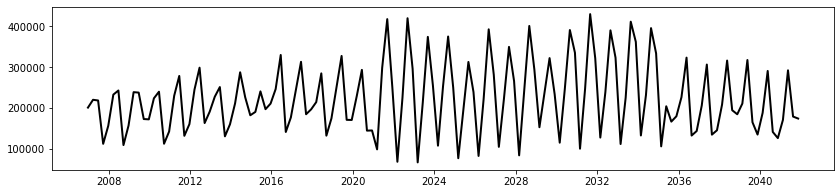

In [43]:
pelagic_control = np.ma.filled(control.variables['PicoPhytopl_N'][start:end,:,5], np.nan)
#pelagic_control = pelagic_control.sum(axis=2)
pelagic_control = pelagic_control.sum(axis=1)

fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time[start:end], pelagic_control, 'k', linewidth = 2);

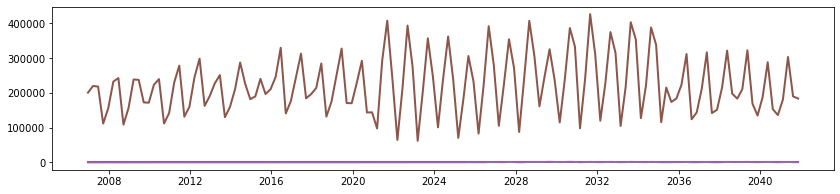

In [44]:
pelagic_oiled = np.ma.filled(scenario3.variables['PicoPhytopl_N'][start:end,:,0:6], np.nan) # tonnes
#pelagic_oiled = pelagic_oiled.sum(axis=2) 
pelagic_oiled = pelagic_oiled.sum(axis=1) 
fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time[start:end], pelagic_oiled,linewidth = 2);

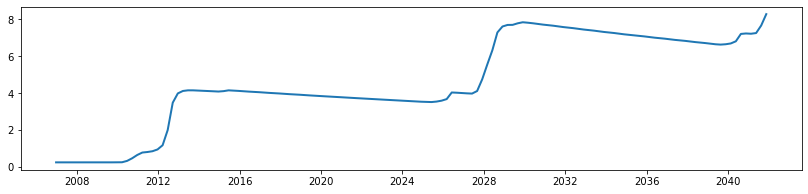

In [45]:
pelagic_oiled = np.ma.filled(scenario3.variables['PicoPhytopl_N'][start:end,:,6], np.nan) # tonnes
#pelagic_oiled = pelagic_oiled.sum(axis=2) 
pelagic_oiled = pelagic_oiled.sum(axis=1) 
fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time[start:end], pelagic_oiled,linewidth = 2);

In [35]:
pelagic_oiled1 = scenario4.PicoPhytopl_N[start:end,:,:]
pelagic_control1 = control.PicoPhytopl_N[start:end,:,:]
pelagic_oiled1 = pelagic_oiled1.sum(axis=2) 
pelagic_oiled1 = pelagic_oiled1.sum(axis=1) 
pelagic_control1 = pelagic_control1.sum(axis=2)
pelagic_control1 = pelagic_control1.sum(axis=1)

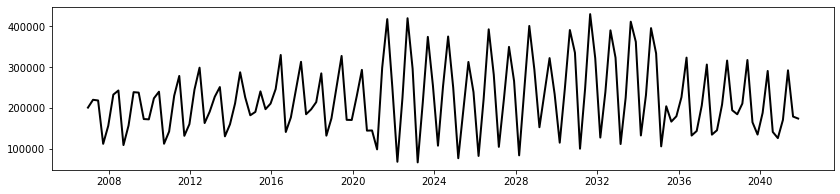

In [36]:
fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time[start:end], pelagic_control1, 'k', linewidth = 2);

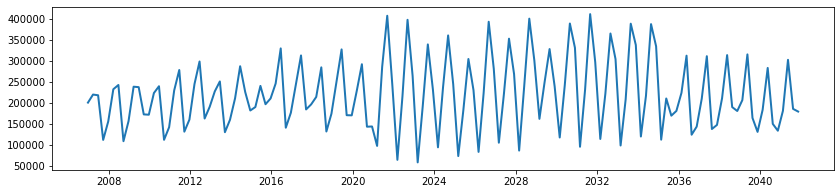

In [37]:
fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time[start:end], pelagic_oiled1,linewidth = 2);